### 1. Preparación de los Datos

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilos de visualización
sns.set(style="whitegrid")
%matplotlib inline

# Carga del dataset (ya limpio de valores faltantes)
df = pd.read_csv('movie_data.csv', sep=';').dropna()

# Transformación de 'release_date' a tipo datetime y extracción del año
df['release_date'] = pd.to_datetime(df['release_date'], format='%Y-%m-%d')
df['release_year'] = df['release_date'].dt.year

from sklearn.preprocessing import StandardScaler

# Selección de variables numéricas
numerical_features = [
    'budget', 'popularity', 'production_companies',
    'production_countries', 'revenue', 'runtime',
    'spoken_languages', 'vote_average', 'vote_count',
    'release_year'
]

# Transformación de variables categóricas ('genres') usando One-Hot Encoding
# genres_dummies = pd.get_dummies(df['genres'], prefix='genre')

# Combinación de variables numéricas y categóricas
X = pd.concat([df[numerical_features]], axis=1).values  # Convertimos a numpy array

# Escalado de las variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Estructura del DataFrame:
       budget     genres    imdb_id     original_title  \
0  30000000.0  Animation  tt0114709          Toy Story   
1  65000000.0  Adventure  tt0113497            Jumanji   
2  16000000.0     Comedy  tt0114885  Waiting to Exhale   
3  60000000.0     Action  tt0113277               Heat   
4  35000000.0     Action  tt0114576       Sudden Death   

                                            overview  popularity  \
0  Led by Woody, Andy's toys live happily in his ...   21.946943   
1  When siblings Judy and Peter discover an encha...   17.015539   
2  Cheated on, mistreated and stepped on, the wom...    3.859495   
3  Obsessive master thief, Neil McCauley leads a ...   17.924927   
4  International action superstar Jean Claude Van...    5.231580   

   production_companies  production_countries release_date      revenue  \
0                   1.0                   1.0   1995-10-30  373554033.0   
1                   3.0                   1.0   1995-12-15  262797

### 2. Implementación de K-Means desde Cero

In [12]:
def euclidean_distance(a, b):
    """Calcula la distancia Euclidiana entre dos puntos."""
    return np.sqrt(np.sum((a - b) ** 2))

In [13]:
class KMeansFromScratch:
    def __init__(self, n_clusters=4, max_iters=100, distance_metric='euclidean', tol=1e-4, verbose=False):
        """
        Inicializa el algoritmo K-Means.
        
        Parámetros:
        - n_clusters: Número de clusters.
        - max_iters: Número máximo de iteraciones.
        - distance_metric: Métrica de distancia ('euclidean').
        - tol: Tolerancia para la convergencia.
        - verbose: Si es True, imprime información durante el entrenamiento.
        """
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.distance_metric = distance_metric
        self.tol = tol
        self.verbose = verbose
        self.centroids = None
        self.labels = None
        self.inertia_ = None  # Suma de las distancias al cuadrado
        
        # Asignación de la función de distancia
        if self.distance_metric == 'euclidean':
            self.distance_func = euclidean_distance
        else:
            raise ValueError("Métrica de distancia no soportada.")
    
    def initialize_centroids(self, X):
        """Inicializa los centroides seleccionando aleatoriamente K puntos del dataset."""
        np.random.seed(42)  # Para reproducibilidad
        random_indices = np.random.permutation(X.shape[0])[:self.n_clusters]
        self.centroids = X[random_indices]
        if self.verbose:
            print(f"Centroides iniciales:\n{self.centroids}\n")
    
    def assign_clusters(self, X):
        """Asigna cada punto al cluster cuyo centroide está más cercano."""
        labels = []
        for idx, point in enumerate(X):
            distances = [self.distance_func(point, centroid) for centroid in self.centroids]
            closest_cluster = np.argmin(distances)
            labels.append(closest_cluster)
            if self.verbose and idx < 5:  # Mostrar las primeras 5 asignaciones
                print(f"Punto {idx}: Asignado al cluster {closest_cluster} con distancia {distances[closest_cluster]:.4f}")
        return np.array(labels)
    
    def update_centroids(self, X, labels):
        """Actualiza los centroides calculando el promedio de los puntos asignados a cada cluster."""
        new_centroids = np.array([X[labels == i].mean(axis=0) if np.any(labels == i) else self.centroids[i] for i in range(self.n_clusters)])
        return new_centroids
    
    def calculate_inertia(self, X):
        """Calcula la inercia como la suma de las distancias al cuadrado de cada punto a su centroide."""
        inertia = 0.0
        for idx, point in enumerate(X):
            centroid = self.centroids[self.labels[idx]]
            distance = self.distance_func(point, centroid)
            inertia += distance ** 2
        return inertia
    
    def fit(self, X):
        """Entrena el modelo K-Means sobre el dataset X."""
        self.initialize_centroids(X)
        for i in range(self.max_iters):
            if self.verbose:
                print(f"Iteración {i+1}")
            
            # Asignación de clusters
            labels = self.assign_clusters(X)
            
            # Verificación de clusters vacíos
            empty_clusters = [idx for idx in range(self.n_clusters) if np.sum(labels == idx) == 0]
            if empty_clusters:
                if self.verbose:
                    print(f"Clusters vacíos encontrados: {empty_clusters}. Reinicializando centroides.")
                for idx in empty_clusters:
                    self.centroids[idx] = X[np.random.choice(len(X))]
            
            # Actualización de centroides
            new_centroids = self.update_centroids(X, labels)
            
            # Cálculo de la diferencia entre los nuevos y antiguos centroides
            centroid_shifts = np.linalg.norm(new_centroids - self.centroids, axis=1)
            if self.verbose:
                print(f"Desplazamiento de centroides: {centroid_shifts}\n")
            
            # Verificación de la convergencia
            if np.all(centroid_shifts <= self.tol):
                if self.verbose:
                    print("Convergencia alcanzada.\n")
                break
            
            self.centroids = new_centroids
        
        self.labels = labels
        self.centroids = new_centroids
        self.inertia_ = self.calculate_inertia(X)
    
    def predict(self, X):
        """Asigna clusters a nuevos puntos basándose en los centroides entrenados."""
        return self.assign_clusters(X)

### 3. Método del Codo para Determinar K Óptimo

In [14]:
from kneed import KneeLocator

def elbow_method(X, max_K=10, distance_metric='euclidean', verbose=False):
    """
    Aplica el método del codo para determinar el número óptimo de clusters.
    
    Parámetros:
    - X: Datos escalados.
    - max_K: Máximo número de clusters a evaluar.
    - distance_metric: Métrica de distancia a utilizar.
    - verbose: Si es True, imprime información durante el entrenamiento.
    
    Retorna:
    - best_K: Número óptimo de clusters determinado por el método del codo.
    - K_range: Rango de K evaluados.
    - inertia_values: Inercia correspondiente a cada K.
    """
    inertia_values = []
    K_range = range(1, max_K + 1)
    
    for K in K_range:
        kmeans = KMeansFromScratch(n_clusters=K, max_iters=100, distance_metric=distance_metric, verbose=verbose)
        kmeans.fit(X)
        inertia_values.append(kmeans.inertia_)
        if verbose:
            print(f"K={K}, Inercia={kmeans.inertia_:.2f}")
    
    # Identificación del "codo" utilizando KneeLocator
    kn = KneeLocator(K_range, inertia_values, curve='convex', direction='decreasing')
    best_K = kn.knee
    if best_K is None:
        best_K = 4  # Valor por defecto si no se detecta el codo
    
    return best_K, K_range, inertia_values

### 4. Aplicación del Método del Codo


Mejor K según el método del codo: 5


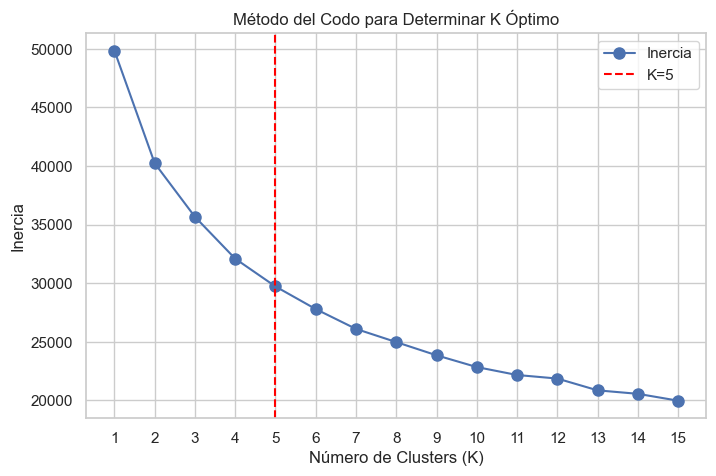

In [15]:
# Aplicación del Método del Codo
best_K, K_range, inertia_values = elbow_method(X_scaled, max_K=15, distance_metric='euclidean', verbose=False)
print(f"\nMejor K según el método del codo: {best_K}")


### 5. Aplicación de K-Means con K Óptimo

In [16]:
# Inicialización y entrenamiento del modelo K-Means
kmeans_optimal = KMeansFromScratch(n_clusters=best_K, max_iters=100, distance_metric='euclidean', verbose=True)
kmeans_optimal.fit(X_scaled)

# Asignación de etiquetas al DataFrame original
df['kmeans_cluster'] = kmeans_optimal.labels

Centroides iniciales:
[[ 2.11794121  2.89495745 -0.42319459 -0.46617377  2.98011391 -0.85070755
  -0.52634212  1.34817875  4.5858622   0.09718531]
 [-0.59092032  0.0105746  -0.8849288  -0.46617377 -0.52202964 -0.57194536
  -0.52634212 -0.6524798  -0.46808824  0.48421812]
 [-0.54028739 -0.63550618  0.03853961  0.83691657 -0.45758655 -0.525485
  -0.52634212 -1.87510448 -0.55417758 -0.16083657]
 [-0.75041403 -1.1977429   0.03853961 -0.46617377 -0.57095099 -0.94362828
  -0.52634212 -0.6524798  -0.59469021  0.35520718]
 [-0.52762916 -0.76475787  0.03853961  0.83691657 -0.4979481  -0.99008865
  -0.52634212 -1.98625217 -0.56092968 -0.61237486]]

Iteración 1
Punto 0: Asignado al cluster 0 con distancia 2.7716
Punto 1: Asignado al cluster 1 con distancia 3.7995
Punto 2: Asignado al cluster 1 con distancia 1.9266
Punto 3: Asignado al cluster 1 con distancia 5.0978
Punto 4: Asignado al cluster 3 con distancia 1.4801
Desplazamiento de centroides: [2.65508416 1.62793976 2.14161585 1.18201229 1.8878

# Comparaciones

## 1. K-Means de scikit-learn

In [17]:
from sklearn.cluster import KMeans as SklearnKMeans

# Aplicación de K-Means de scikit-learn
sklearn_kmeans = SklearnKMeans(n_clusters=best_K, random_state=42)
sklearn_kmeans.fit(X_scaled)

# Comparación de las inercias
print(f"\nInercia scikit-learn: {sklearn_kmeans.inertia_:.2f}")
print(f"Inercia KMeansFromScratch: {kmeans_optimal.inertia_:.2f}")

# Comparación de etiquetas
comparison = pd.DataFrame({
    'FromScratch': kmeans_optimal.labels,
    'Sklearn': sklearn_kmeans.labels_
})

print("\nComparación de etiquetas entre KMeansFromScratch y scikit-learn:")
print(comparison.head())


Inercia scikit-learn: 29694.56
Inercia KMeansFromScratch: 29721.97

Comparación de etiquetas entre KMeansFromScratch y scikit-learn:
   FromScratch  Sklearn
0            0        3
1            1        2
2            3        4
3            1        2
4            3        4


## 2. Operaciones vectorizadas con NumPy

Para mejorar la eficiencia, puedes vectorizar algunas operaciones en la clase `KMeansFromScratch`. Actualmente, el método `assign_clusters` itera sobre cada punto, lo que puede ser lento para datasets grandes. Utilizar operaciones vectorizadas con NumPy puede acelerar significativamente el proceso.

In [18]:
class KMeansFromScratchVectorized:
    def __init__(self, n_clusters=4, max_iters=100, distance_metric='euclidean', tol=1e-4, verbose=False):
        # Misma inicialización que antes
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.distance_metric = distance_metric
        self.tol = tol
        self.verbose = verbose
        self.centroids = None
        self.labels = None
        self.inertia_ = None
        
        if self.distance_metric == 'euclidean':
            self.distance_func = euclidean_distance
        else:
            raise ValueError("Métrica de distancia no soportada.")
    
    def initialize_centroids(self, X):
        np.random.seed(42)
        random_indices = np.random.permutation(X.shape[0])[:self.n_clusters]
        self.centroids = X[random_indices]
        if self.verbose:
            print(f"Centroides iniciales:\n{self.centroids}\n")
    
    def assign_clusters(self, X):
        # Vectorización del cálculo de distancias
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        self.labels = np.argmin(distances, axis=1)
        if self.verbose:
            for idx in range(min(5, X.shape[0])):
                print(f"Punto {idx}: Asignado al cluster {self.labels[idx]} con distancia {distances[idx][self.labels[idx]]:.4f}")
        return self.labels
    
    def update_centroids(self, X):
        new_centroids = np.array([X[self.labels == i].mean(axis=0) for i in range(self.n_clusters)])
        return new_centroids
    
    def calculate_inertia(self, X):
        inertia = 0.0
        for i in range(self.n_clusters):
            cluster_points = X[self.labels == i]
            inertia += np.sum((cluster_points - self.centroids[i]) ** 2)
        return inertia
    
    def fit(self, X):
        self.initialize_centroids(X)
        for i in range(self.max_iters):
            if self.verbose:
                print(f"Iteración {i+1}")
            
            # Asignación de clusters
            self.assign_clusters(X)
            
            # Actualización de centroides
            new_centroids = self.update_centroids(X)
            
            # Cálculo de la diferencia entre los nuevos y antiguos centroides
            centroid_shifts = np.linalg.norm(new_centroids - self.centroids, axis=1)
            if self.verbose:
                print(f"Desplazamiento de centroides: {centroid_shifts}\n")
            
            # Verificación de la convergencia
            if np.all(centroid_shifts <= self.tol):
                if self.verbose:
                    print("Convergencia alcanzada.\n")
                break
            
            self.centroids = new_centroids
        
        self.inertia_ = self.calculate_inertia(X)
    
    def predict(self, X):
        return self.assign_clusters(X)

In [19]:
# Inicialización y entrenamiento del modelo K-Means vectorizado
kmeans_optimal_vec = KMeansFromScratchVectorized(n_clusters=best_K, max_iters=100, distance_metric='euclidean', verbose=True)
kmeans_optimal_vec.fit(X_scaled)

# Asignación de etiquetas al DataFrame original
df['kmeans_cluster_vec'] = kmeans_optimal_vec.labels

Centroides iniciales:
[[ 2.11794121  2.89495745 -0.42319459 -0.46617377  2.98011391 -0.85070755
  -0.52634212  1.34817875  4.5858622   0.09718531]
 [-0.59092032  0.0105746  -0.8849288  -0.46617377 -0.52202964 -0.57194536
  -0.52634212 -0.6524798  -0.46808824  0.48421812]
 [-0.54028739 -0.63550618  0.03853961  0.83691657 -0.45758655 -0.525485
  -0.52634212 -1.87510448 -0.55417758 -0.16083657]
 [-0.75041403 -1.1977429   0.03853961 -0.46617377 -0.57095099 -0.94362828
  -0.52634212 -0.6524798  -0.59469021  0.35520718]
 [-0.52762916 -0.76475787  0.03853961  0.83691657 -0.4979481  -0.99008865
  -0.52634212 -1.98625217 -0.56092968 -0.61237486]]

Iteración 1
Punto 0: Asignado al cluster 0 con distancia 2.7716
Punto 1: Asignado al cluster 1 con distancia 3.7995
Punto 2: Asignado al cluster 1 con distancia 1.9266
Punto 3: Asignado al cluster 1 con distancia 5.0978
Punto 4: Asignado al cluster 3 con distancia 1.4801
Desplazamiento de centroides: [2.65508416 1.62793976 2.14161585 1.18201229 1.8878

In [20]:
# Comparación de inercias
print(f"\nInercia KMeansFromScratch: {kmeans_optimal.inertia_:.2f}")
print(f"Inercia KMeansFromScratchVectorized: {kmeans_optimal_vec.inertia_:.2f}")


Inercia KMeansFromScratch: 29721.97
Inercia KMeansFromScratchVectorized: 29721.97


## 3. Implementación de K-Means++

K-Means++ es una técnica de inicialización de centroides que mejora la convergencia y la calidad de los clusters al seleccionar centroides iniciales más dispersos.

In [21]:
class KMeansPlusPlus:
    def __init__(self, n_clusters=4, max_iters=100, distance_metric='euclidean', tol=1e-4, verbose=False):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.distance_metric = distance_metric
        self.tol = tol
        self.verbose = verbose
        self.centroids = None
        self.labels = None
        self.inertia_ = None
        
        if self.distance_metric == 'euclidean':
            self.distance_func = euclidean_distance
        else:
            raise ValueError("Métrica de distancia no soportada.")
    
    def initialize_centroids_pp(self, X):
        """Inicializa los centroides utilizando el método K-Means++."""
        np.random.seed(42)
        n_samples, n_features = X.shape
        centroids = []
        
        # Selección del primer centroide aleatoriamente
        first_centroid_idx = np.random.choice(n_samples)
        centroids.append(X[first_centroid_idx])
        
        for _ in range(1, self.n_clusters):
            distances = np.array([min([self.distance_func(x, c) for c in centroids]) for x in X])
            probabilities = distances ** 2
            probabilities /= probabilities.sum()
            next_centroid_idx = np.random.choice(n_samples, p=probabilities)
            centroids.append(X[next_centroid_idx])
        
        self.centroids = np.array(centroids)
        if self.verbose:
            print(f"Centroides iniciales (K-Means++):\n{self.centroids}\n")
    
    def assign_clusters(self, X):
        """Asigna cada punto al cluster cuyo centroide está más cercano."""
        labels = []
        for idx, point in enumerate(X):
            distances = [self.distance_func(point, centroid) for centroid in self.centroids]
            closest_cluster = np.argmin(distances)
            labels.append(closest_cluster)
        return np.array(labels)
    
    def update_centroids(self, X, labels):
        """Actualiza los centroides calculando el promedio de los puntos asignados a cada cluster."""
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(self.n_clusters)])
        return new_centroids
    
    def calculate_inertia(self, X):
        """Calcula la inercia como la suma de las distancias al cuadrado de cada punto a su centroide."""
        inertia = 0.0
        for idx, point in enumerate(X):
            centroid = self.centroids[self.labels[idx]]
            distance = self.distance_func(point, centroid)
            inertia += distance ** 2
        return inertia
    
    def fit(self, X):
        """Entrena el modelo K-Means++ sobre el dataset X."""
        self.initialize_centroids_pp(X)
        for i in range(self.max_iters):
            if self.verbose:
                print(f"Iteración {i+1}")
            
            # Asignación de clusters
            labels = self.assign_clusters(X)
            
            # Actualización de centroides
            new_centroids = self.update_centroids(X, labels)
            
            # Cálculo de la diferencia entre los nuevos y antiguos centroides
            centroid_shifts = np.linalg.norm(new_centroids - self.centroids, axis=1)
            if self.verbose:
                print(f"Desplazamiento de centroides: {centroid_shifts}\n")
            
            # Verificación de la convergencia
            if np.all(centroid_shifts <= self.tol):
                if self.verbose:
                    print("Convergencia alcanzada.\n")
                break
            
            self.centroids = new_centroids
        
        self.labels = labels
        self.centroids = new_centroids
        self.inertia_ = self.calculate_inertia(X)
    
    def predict(self, X):
        """Asigna clusters a nuevos puntos basándose en los centroides entrenados."""
        return self.assign_clusters(X)

In [22]:
# Inicialización y entrenamiento del modelo K-Means++ con K=4
kmeans_pp = KMeansPlusPlus(n_clusters=best_K, max_iters=100, distance_metric='euclidean', verbose=True)
kmeans_pp.fit(X_scaled)

# Asignación de etiquetas al DataFrame original
df['kmeans_pp_cluster'] = kmeans_pp.labels

Centroides iniciales (K-Means++):
[[ 0.57363698  0.18301787  0.03853961  0.83691657  0.63068673  0.77540522
  -0.52634212  0.23670178 -0.06296195 -1.25742955]
 [-0.76307226 -0.72108005 -0.8849288  -0.46617377 -0.55462655 -1.1759301
  -0.52634212  0.23670178 -0.51957304 -0.03182563]
 [-0.41370508  0.44404351 -0.8849288  -0.46617377  0.20963439  0.58956376
   2.69241755  1.68162185  2.26735821  0.93575641]
 [-0.75547732  1.35178206  0.50027382  0.83691657  0.04105742 -0.33964354
  -0.52634212  0.57014487  0.89330489  0.67773453]
 [ 1.13059916  0.82455939  0.03853961  0.83691657 -0.12961347 -0.06088135
  -0.52634212  1.23703106  1.18448941  0.41971265]]

Iteración 1
Desplazamiento de centroides: [1.24420331 1.20129332 2.34158369 1.46168555 2.20702879]

Iteración 2
Desplazamiento de centroides: [0.710344   0.15734253 0.86026765 0.45850569 0.9121632 ]

Iteración 3
Desplazamiento de centroides: [0.31425282 0.13807052 0.37938068 0.17858971 0.49226333]

Iteración 4
Desplazamiento de centroides

In [23]:
# Comparación de inercias
print(f"\nInercia KMeansPlusPlus: {kmeans_pp.inertia_:.2f}")
print(f"Inercia KMeansFromScratch: {kmeans_optimal.inertia_:.2f}")


Inercia KMeansPlusPlus: 30097.58
Inercia KMeansFromScratch: 29721.97
